# Experiments Overview (exp01–exp10)
> **Note on reproducibility:** This notebook **does not run** the Monte Carlo experiments. This notebook is a *read + visualize* layer.   
> It **loads the CSV outputs** from `paper/tables/` and produces  plots saved to `paper/figures/`.

 **Prereqs**
- Get data and run all experiments first:
  - `python scripts/get_data.py`
  - `python scripts/run_all_experiments.py`
- Then run this notebook.




## Research Question

This study investigates the statistical behavior and robustness of Monte Carlo Value-at-Risk (VaR) and Expected Shortfall (ES) estimators under:

- Heavy-tailed returns
- Finite-sample effects
- Model misspecification
- Variance reduction techniques
- Conditional volatility (GARCH)

We progressively move from classical Monte Carlo estimation to backtesting under realistic financial dynamics.

The goal is to understand:
1. Large-sample properties of quantile estimators
2. Finite-sample concentration bounds
3. Variance reduction efficiency
4. The effect of heavy tails
5. Calibration quality of VaR/ES under dynamic volatility

In [66]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).parent

TABLE_DIR = PROJECT_ROOT / "paper" / "tables"
FIG_DIR = PROJECT_ROOT / "paper" / "figures"

FIG_DIR.mkdir(parents=True, exist_ok=True)

def load_csv(name: str) -> pd.DataFrame | None:
    path = TABLE_DIR / name
    if not path.exists():
        print(f"[missing] {path}")
        return None
    df = pd.read_csv(path)
    print(f"[loaded] {path}  shape={df.shape}")
    return df

def savefig(name: str) -> None:
    out = FIG_DIR / name
    plt.tight_layout()
    plt.savefig(out, dpi=200)
    print(f"[saved] {out}")


> ## Load all experiment outputs

In [67]:
exp01 = load_csv("exp01_classical_var.csv")
exp02 = load_csv("exp02_normal_vs_t.csv")
exp03 = load_csv("exp03_asymptotics_summary.csv")
exp04 = load_csv("exp04_dkw_bounds.csv")
exp05 = load_csv("exp05_variance_reduction.csv")
exp06 = load_csv("exp06_importance_sampling.csv")
exp07 = load_csv("exp07_misspecification.csv")
exp07n = load_csv("exp07_misspecification_normal.csv")
exp08 = load_csv("exp08_es_backtesting.csv")
exp09 = load_csv("exp09_garch_var_es.csv")
exp10 = load_csv("exp10_garch_t_var_es.csv")


[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp01_classical_var.csv  shape=(2, 8)
[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp02_normal_vs_t.csv  shape=(3, 8)
[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp03_asymptotics_summary.csv  shape=(4, 12)
[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp04_dkw_bounds.csv  shape=(4, 10)
[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp05_variance_reduction.csv  shape=(2, 12)
[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp06_importance_sampling.csv  shape=(2, 13)
[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp07_misspecification.csv  shape=(2, 11)
[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp07_misspecification_normal.csv  shape=(2, 11)
[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp08_es_backtesting.csv  shape=(2, 18)
[loa

> ## exp01–exp02: VaR/CVaR comparison (Normal vs Bootstrap vs t)

Interpretation:
- Normal often underestimates tail risk vs bootstrap / heavy-tailed t.


[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp01_var_cvar.png


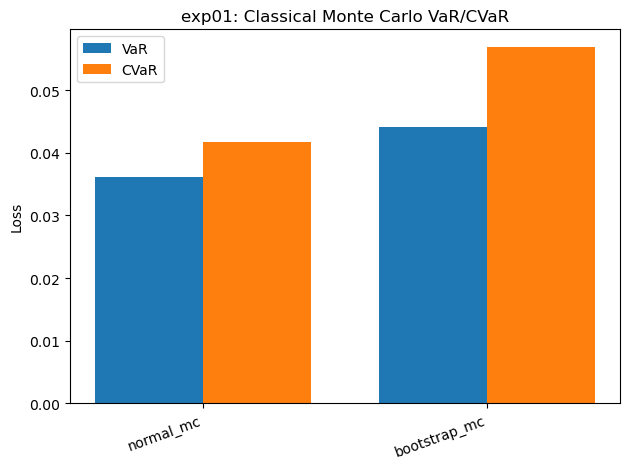

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp02_var_cvar.png


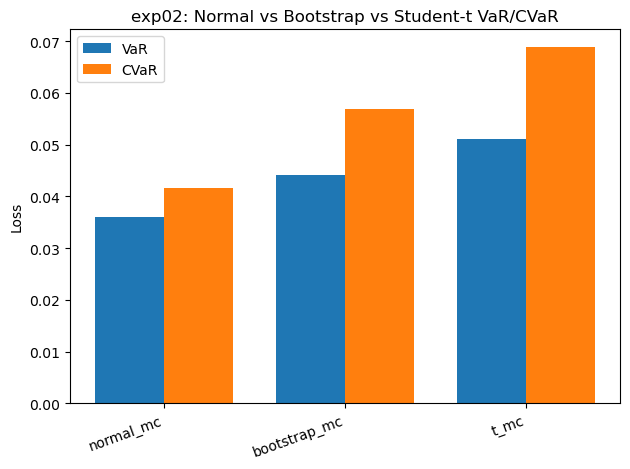

In [68]:
def plot_var_cvar(df: pd.DataFrame, title: str, fname: str) -> None:
    if df is None or df.empty:
        print("No data to plot.")
        return

    methods = df["method"].astype(str).tolist()
    var = df["VaR"].to_numpy(dtype=float)
    cvar = df["CVaR"].to_numpy(dtype=float)

    x = np.arange(len(methods))
    width = 0.38

    plt.figure()
    plt.bar(x - width/2, var, width, label="VaR")
    plt.bar(x + width/2, cvar, width, label="CVaR")
    plt.xticks(x, methods, rotation=20, ha="right")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    savefig(fname)
    plt.show()

plot_var_cvar(exp01, "exp01: Classical Monte Carlo VaR/CVaR", "exp01_var_cvar.png")
plot_var_cvar(exp02, "exp02: Normal vs Bootstrap vs Student-t VaR/CVaR", "exp02_var_cvar.png")


## exp03: Asymptotic normality study

We visualize:
- RMSE vs sample size `n` (log-log)
- Coverage of asymptotic CI vs `n`
- Average CI width vs `n`
- KDE density-at-quantile diagnostics (`fhat_*`) if present


[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp03_rmse_loglog.png


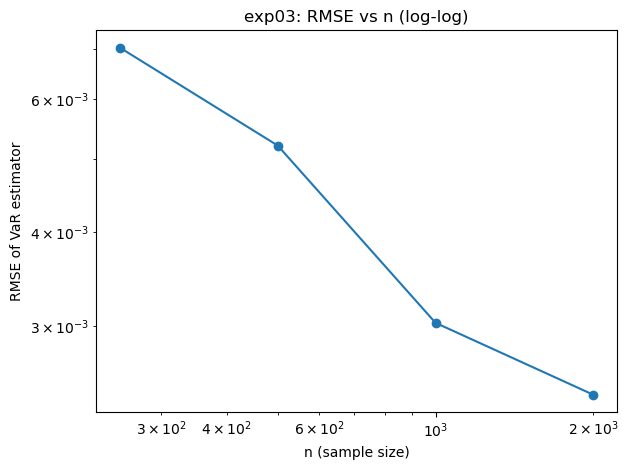

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp03_coverage.png


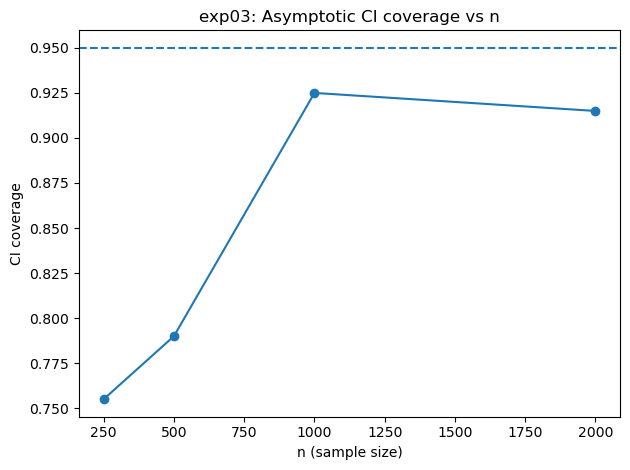

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp03_ci_width.png


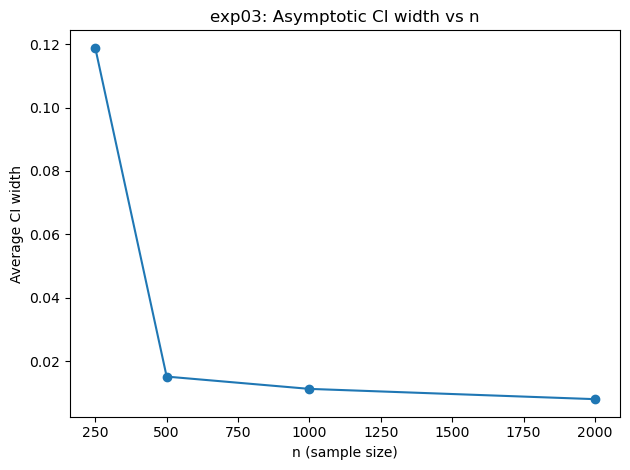

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp03_fhat_diagnostics.png


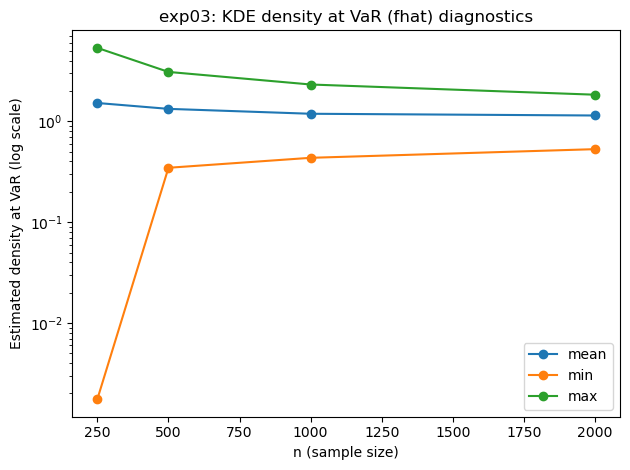

In [69]:
def plot_exp03(df: pd.DataFrame) -> None:
    if df is None or df.empty:
        print("No exp03 data.")
        return
    df = df.sort_values("n")

    n = df["n"].to_numpy(dtype=float)
    rmse = df["rmse"].to_numpy(dtype=float)
    coverage = df["coverage"].to_numpy(dtype=float)
    width = df["avg_ci_width"].to_numpy(dtype=float)

    # RMSE log-log
    plt.figure()
    plt.loglog(n, rmse, marker="o")
    plt.xlabel("n (sample size)")
    plt.ylabel("RMSE of VaR estimator")
    plt.title("exp03: RMSE vs n (log-log)")
    savefig("exp03_rmse_loglog.png")
    plt.show()

    # Coverage
    plt.figure()
    plt.plot(n, coverage, marker="o")
    plt.axhline(df["conf"].iloc[0], linestyle="--")
    plt.xlabel("n (sample size)")
    plt.ylabel("CI coverage")
    plt.title("exp03: Asymptotic CI coverage vs n")
    savefig("exp03_coverage.png")
    plt.show()

    # Width
    plt.figure()
    plt.plot(n, width, marker="o")
    plt.xlabel("n (sample size)")
    plt.ylabel("Average CI width")
    plt.title("exp03: Asymptotic CI width vs n")
    savefig("exp03_ci_width.png")
    plt.show()

    # fhat diagnostics if available
    if {"fhat_mean", "fhat_min", "fhat_max"}.issubset(df.columns):
        plt.figure()
        plt.plot(n, df["fhat_mean"], marker="o", label="mean")
        plt.plot(n, df["fhat_min"], marker="o", label="min")
        plt.plot(n, df["fhat_max"], marker="o", label="max")
        plt.yscale("log")
        plt.xlabel("n (sample size)")
        plt.ylabel("Estimated density at VaR (log scale)")
        plt.title("exp03: KDE density at VaR (fhat) diagnostics")
        plt.legend()
        savefig("exp03_fhat_diagnostics.png")
        plt.show()

plot_exp03(exp03)


### Interpretation (why the CI width can “blow up” at small $n$)

The asymptotic CI for the sample quantile depends on the density at the true quantile via
$$
\sqrt{n}\,(\hat q_\alpha - q_\alpha)
\;\approx\;
\mathcal{N}\!\left(
0,\,
\frac{\alpha(1-\alpha)}{f(q_\alpha)^2}
\right).
$$

In practice we plug in an estimate $\hat f(\hat q_\alpha).$

If $\hat f(\hat q_\alpha)$ is very small (common in extreme tails and small samples), then the CI width scales like $ \frac{1}{\hat f(\hat q_\alpha)}, $ and can become extremely large.

That is why, for small $ n, $ the asymptotic CI can have unstable width—even if RMSE is decreasing with $ n. $

In our runs, the $ n = 250 $ case shows a very small `fhat_min`, consistent with the observed CI width spike.

> ## exp04: DKW finite-sample brackets vs asymptotic CI

We compare:
- Coverage: asymptotic CI vs DKW bracket
- Width: asymptotic CI vs DKW bracket


[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp04_coverage_compare.png


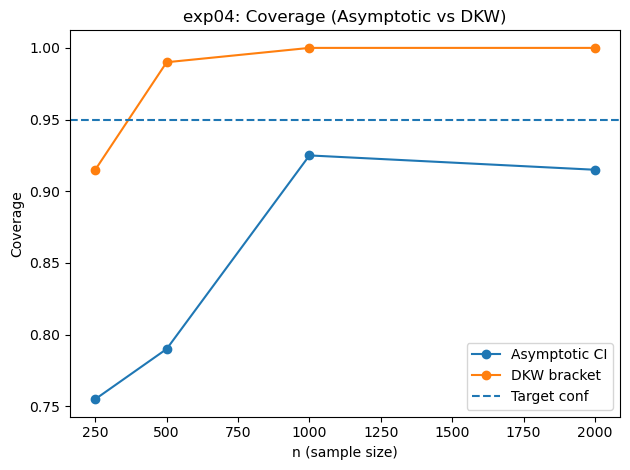

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp04_width_compare.png


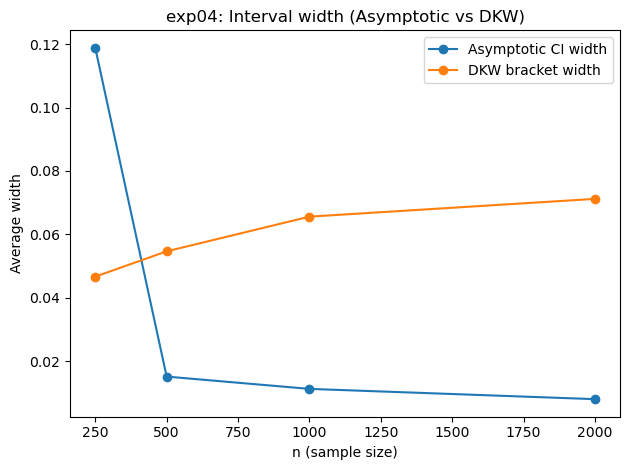

In [70]:
def plot_exp04(df: pd.DataFrame) -> None:
    if df is None or df.empty:
        print("No exp04 data.")
        return
    df = df.sort_values("n")
    n = df["n"].to_numpy(dtype=float)

    cov_asym = df["coverage_asym"].to_numpy(dtype=float)
    cov_dkw = df["coverage_dkw"].to_numpy(dtype=float)

    w_asym = df["avg_width_asym"].to_numpy(dtype=float)
    w_dkw = df["avg_width_dkw"].to_numpy(dtype=float)

    # Coverage
    plt.figure()
    plt.plot(n, cov_asym, marker="o", label="Asymptotic CI")
    plt.plot(n, cov_dkw, marker="o", label="DKW bracket")
    plt.axhline(df["conf"].iloc[0], linestyle="--", label="Target conf")
    plt.xlabel("n (sample size)")
    plt.ylabel("Coverage")
    plt.title("exp04: Coverage (Asymptotic vs DKW)")
    plt.legend()
    savefig("exp04_coverage_compare.png")
    plt.show()

    # Width
    plt.figure()
    plt.plot(n, w_asym, marker="o", label="Asymptotic CI width")
    plt.plot(n, w_dkw, marker="o", label="DKW bracket width")
    plt.xlabel("n (sample size)")
    plt.ylabel("Average width")
    plt.title("exp04: Interval width (Asymptotic vs DKW)")
    plt.legend()
    savefig("exp04_width_compare.png")
    plt.show()

plot_exp04(exp04)


### Interpretation

The Dvoretzky–Kiefer–Wolfowitz (DKW) inequality provides a non-asymptotic, distribution-free bound on the empirical CDF.

Key observation:
- DKW coverage is conservative and often close to 1.0.
- Asymptotic CI may undercover at small n.
- DKW quantile width does not necessarily shrink monotonically with n because the mapping from CDF error to quantile error depends on the local tail slope (1/f).

Takeaway:
DKW guarantees coverage but may be overly conservative in extreme tails.

> ## exp05: Variance reduction (Plain vs Antithetic)

Quantiles/tail functionals often do **not** benefit from antithetic variates (unlike means).
We plot standard deviation and RMSE of VaR/CVaR across replications.


[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp05_var_std_rmse.png


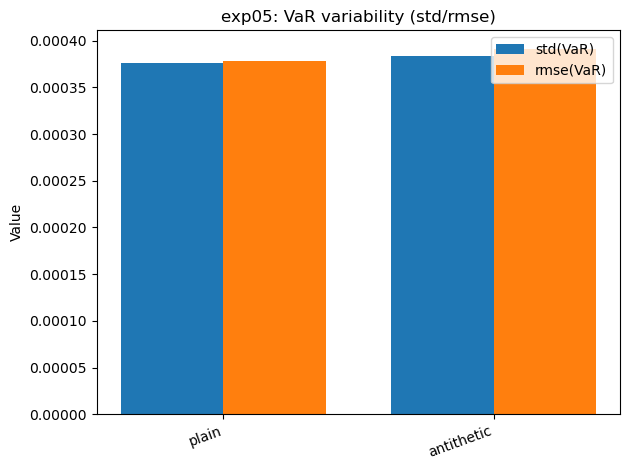

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp05_cvar_std_rmse.png


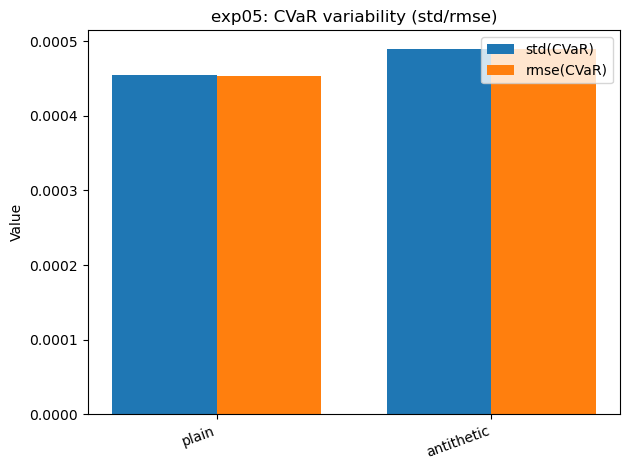

In [71]:
def plot_exp05(df: pd.DataFrame) -> None:
    if df is None or df.empty:
        print("No exp05 data.")
        return
    methods = df["method"].astype(str).tolist()
    x = np.arange(len(methods))
    width = 0.38

    # VaR std + rmse
    plt.figure()
    plt.bar(x - width/2, df["std_var"], width, label="std(VaR)")
    plt.bar(x + width/2, df["rmse_var"], width, label="rmse(VaR)")
    plt.xticks(x, methods, rotation=20, ha="right")
    plt.ylabel("Value")
    plt.title("exp05: VaR variability (std/rmse)")
    plt.legend()
    savefig("exp05_var_std_rmse.png")
    plt.show()

    # CVaR std + rmse
    plt.figure()
    plt.bar(x - width/2, df["std_cvar"], width, label="std(CVaR)")
    plt.bar(x + width/2, df["rmse_cvar"], width, label="rmse(CVaR)")
    plt.xticks(x, methods, rotation=20, ha="right")
    plt.ylabel("Value")
    plt.title("exp05: CVaR variability (std/rmse)")
    plt.legend()
    savefig("exp05_cvar_std_rmse.png")
    plt.show()

plot_exp05(exp05)


### Interpretation

Antithetic variates do not significantly reduce variance for VaR/CVaR estimation.

Reason:
- VaR is a non-smooth functional (a quantile).
- Variance reduction methods are most effective for smooth monotone estimators.
- Order statistics reduce the effectiveness of negative correlation techniques.

This confirms that variance reduction for risk measures requires more targeted methods (e.g., importance sampling).

> ## exp06: Importance sampling vs plain MC

Importance sampling should reduce the variability of tail estimates at fixed budget.
We plot std/rmse for VaR and CVaR.


[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp06_var_std_rmse.png


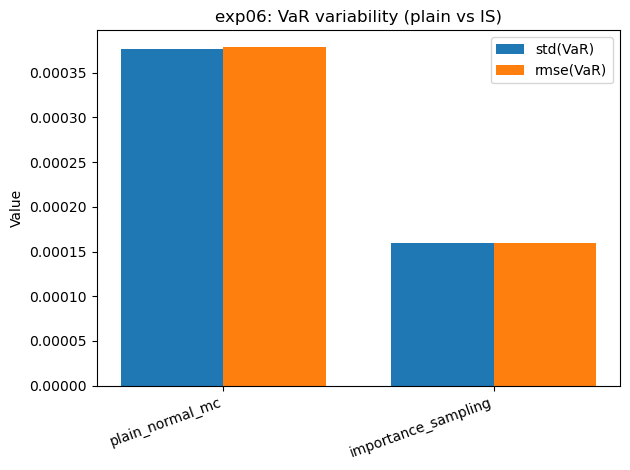

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp06_cvar_std_rmse.png


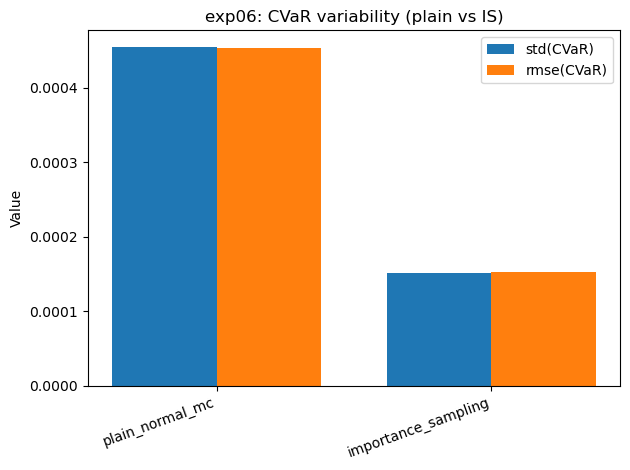

In [72]:
def plot_exp06(df: pd.DataFrame) -> None:
    if df is None or df.empty:
        print("No exp06 data.")
        return
    methods = df["method"].astype(str).tolist()
    x = np.arange(len(methods))
    width = 0.38

    plt.figure()
    plt.bar(x - width/2, df["std_var"], width, label="std(VaR)")
    plt.bar(x + width/2, df["rmse_var"], width, label="rmse(VaR)")
    plt.xticks(x, methods, rotation=20, ha="right")
    plt.ylabel("Value")
    plt.title("exp06: VaR variability (plain vs IS)")
    plt.legend()
    savefig("exp06_var_std_rmse.png")
    plt.show()

    plt.figure()
    plt.bar(x - width/2, df["std_cvar"], width, label="std(CVaR)")
    plt.bar(x + width/2, df["rmse_cvar"], width, label="rmse(CVaR)")
    plt.xticks(x, methods, rotation=20, ha="right")
    plt.ylabel("Value")
    plt.title("exp06: CVaR variability (plain vs IS)")
    plt.legend()
    savefig("exp06_cvar_std_rmse.png")
    plt.show()

plot_exp06(exp06)


## Variance reduction comparison

exp05 vs exp06 side-by-side

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\step1_variance_reduction_std_var.png


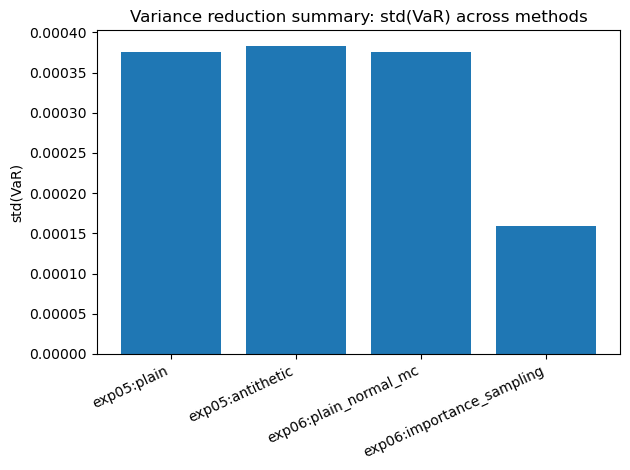

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\step1_variance_reduction_rmse_var.png


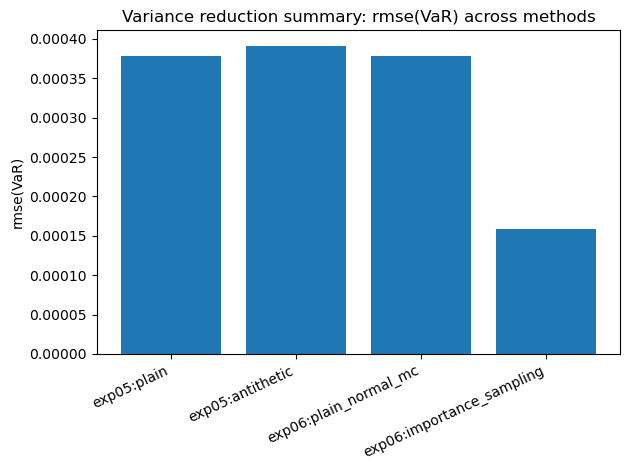

In [73]:
def plot_variance_reduction_summary(exp05: pd.DataFrame, exp06: pd.DataFrame) -> None:
    if exp05 is None or exp06 is None:
        print("Need exp05 and exp06 tables.")
        return

    # Create a combined small table
    s05 = exp05.set_index("method")[["std_var", "rmse_var", "std_cvar", "rmse_cvar"]].copy()
    s05.index = [f"exp05:{m}" for m in s05.index]

    s06 = exp06.set_index("method")[["std_var", "rmse_var", "std_cvar", "rmse_cvar"]].copy()
    s06.index = [f"exp06:{m}" for m in s06.index]

    combo = pd.concat([s05, s06], axis=0)

    # Plot std(VaR)
    plt.figure()
    plt.bar(np.arange(combo.shape[0]), combo["std_var"].to_numpy())
    plt.xticks(np.arange(combo.shape[0]), combo.index.tolist(), rotation=25, ha="right")
    plt.ylabel("std(VaR)")
    plt.title("Variance reduction summary: std(VaR) across methods")
    savefig("step1_variance_reduction_std_var.png")
    plt.show()

    # Plot rmse(VaR)
    plt.figure()
    plt.bar(np.arange(combo.shape[0]), combo["rmse_var"].to_numpy())
    plt.xticks(np.arange(combo.shape[0]), combo.index.tolist(), rotation=25, ha="right")
    plt.ylabel("rmse(VaR)")
    plt.title("Variance reduction summary: rmse(VaR) across methods")
    savefig("step1_variance_reduction_rmse_var.png")
    plt.show()

plot_variance_reduction_summary(exp05, exp06)

### Interpretation

Importance sampling significantly reduces estimator variance when the proposal distribution shifts probability mass toward the tail.

However:
- Overshifting can increase variance.
- Proper tuning of the shift parameter is critical.

A shift sweep (e.g., shift_scale ∈ {0, 0.5, 1.0, 1.5, 2.0}) can reveal an optimal tradeoff.

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp06_shift_std_var.png


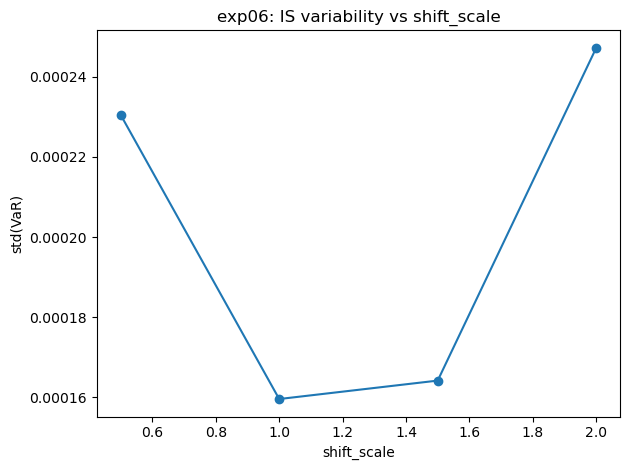

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp06_shift_rmse_var.png


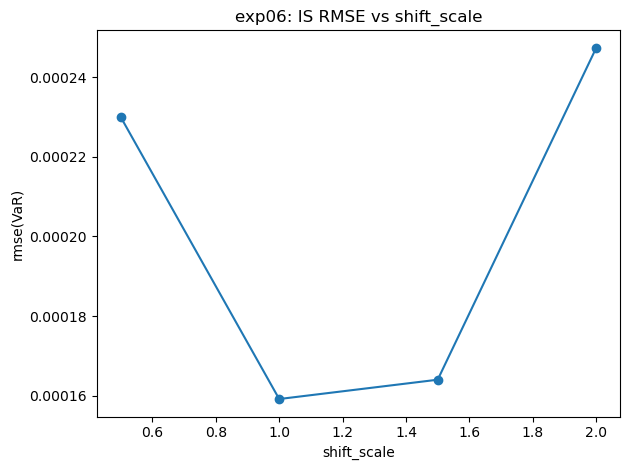

In [74]:
import glob

def plot_exp06_shift_curve():
    paths = sorted(glob.glob(str(TABLE_DIR / "exp06_shift_*.csv")))
    if not paths:
        print("No exp06_shift_*.csv found. Run the exp06 shift YAMLs first.")
        return

    rows = []
    for p in paths:
        df = pd.read_csv(p)
        # pick importance_sampling row
        r = df[df["method"] == "importance_sampling"].iloc[0].to_dict()
        # infer shift from filename if needed
        rows.append(r)

    out = pd.DataFrame(rows)
    out = out.sort_values("shift_scale")

    x = out["shift_scale"].to_numpy(dtype=float)

    plt.figure()
    plt.plot(x, out["std_var"].to_numpy(dtype=float), marker="o")
    plt.xlabel("shift_scale")
    plt.ylabel("std(VaR)")
    plt.title("exp06: IS variability vs shift_scale")
    savefig("exp06_shift_std_var.png")
    plt.show()

    plt.figure()
    plt.plot(x, out["rmse_var"].to_numpy(dtype=float), marker="o")
    plt.xlabel("shift_scale")
    plt.ylabel("rmse(VaR)")
    plt.title("exp06: IS RMSE vs shift_scale")
    savefig("exp06_shift_rmse_var.png")
    plt.show()

plot_exp06_shift_curve()

> ## exp07: Misspecification & backtesting

We compare exception rates and Kupiec LR test.

### Interpretation (why misspecification matters)

This experiment isolates **model risk**: the true data-generating process is heavy-tailed (Student-t), but we forecast VaR under competing assumptions (Gaussian vs Student-t with specified df).

- If the model has **too-light tails** (Gaussian), we tend to see **excess exceptions** at high confidence levels (e.g. 99%).
- A correctly-specified (or closer-to-correct) Student-t model should bring the exception rate closer to the nominal level ( $1 - \alpha$ )

Model labels like `t_model_df5` or `t_model_df1000_approx_normal` make the misspecification explicit and help interpret results quickly.

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp07_exceptions.png


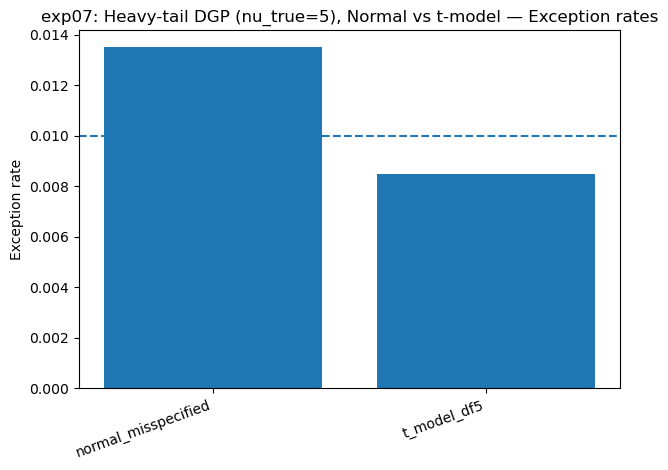

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp07_kupiec_lr.png


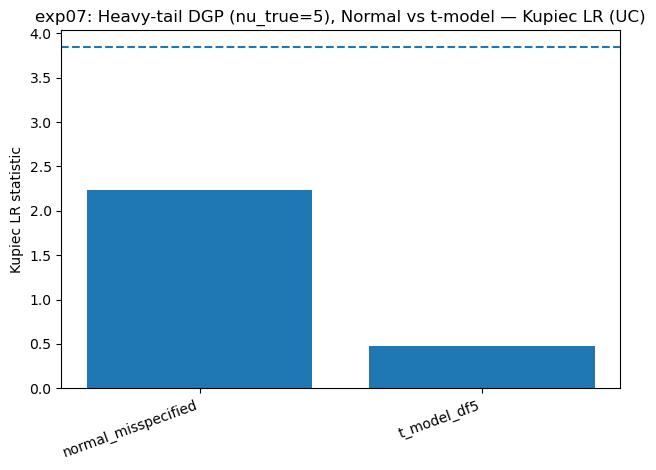

normal_misspecified: exception_rate=0.0135 (expected=0.0100)  -> ok
t_model_df5: exception_rate=0.0085 (expected=0.0100)  -> ok
[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp07_normal_approx_exceptions.png


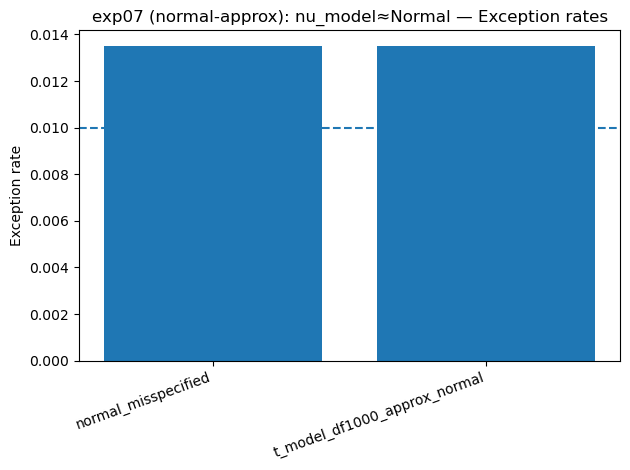

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp07_normal_approx_kupiec_lr.png


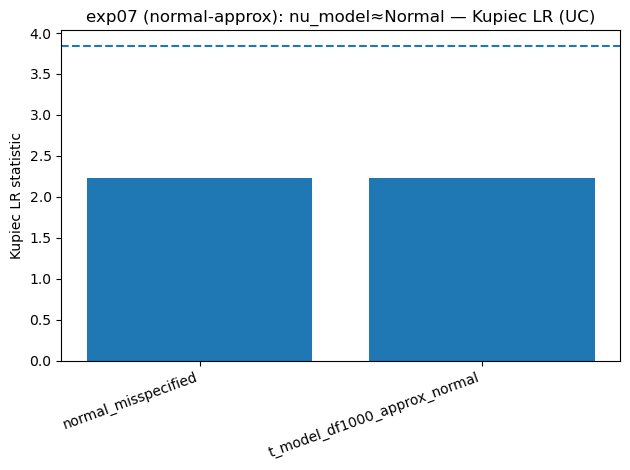

normal_misspecified: exception_rate=0.0135 (expected=0.0100)  -> ok
t_model_df1000_approx_normal: exception_rate=0.0135 (expected=0.0100)  -> ok


In [75]:
def plot_exp07(df: pd.DataFrame, title: str, fname_prefix: str) -> None:
    if df is None or df.empty:
        print("No exp07 data.")
        return

    models = df["model"].astype(str).tolist()
    exc = df["exception_rate"].to_numpy(dtype=float)
    expected = float(df["expected_rate"].iloc[0])
    lr = df["kupiec_lr"].to_numpy(dtype=float)
    crit = float(df["kupiec_crit_5pct"].iloc[0])
    reject = df["reject_5pct"].astype(bool).tolist()

    x = np.arange(len(models))

    # Exception rate
    plt.figure()
    plt.bar(x, exc)
    plt.axhline(expected, linestyle="--")
    plt.xticks(x, models, rotation=20, ha="right")
    plt.ylabel("Exception rate")
    plt.title(title + " — Exception rates")
    savefig(f"{fname_prefix}_exceptions.png")
    plt.show()

    # Kupiec LR
    plt.figure()
    plt.bar(x, lr)
    plt.axhline(crit, linestyle="--")
    plt.xticks(x, models, rotation=20, ha="right")
    plt.ylabel("Kupiec LR statistic")
    plt.title(title + " — Kupiec LR (UC)")
    savefig(f"{fname_prefix}_kupiec_lr.png")
    plt.show()

    for m, e, r in zip(models, exc, reject):
        status = "REJECT" if r else "ok"
        print(f"{m}: exception_rate={e:.4f} (expected={expected:.4f})  -> {status}")

plot_exp07(exp07, "exp07: Heavy-tail DGP (nu_true=5), Normal vs t-model", "exp07")
plot_exp07(exp07n, "exp07 (normal-approx): nu_model≈Normal", "exp07_normal_approx")


> ## Dynamic Volatility & ES Backtesting

Static models fail to capture volatility clustering.

We compare:

- Static Gaussian
- Historical simulation
- GARCH(1,1) with Gaussian innovations
- GARCH(1,1) with Student-t innovations


[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp08_es_ratio.png


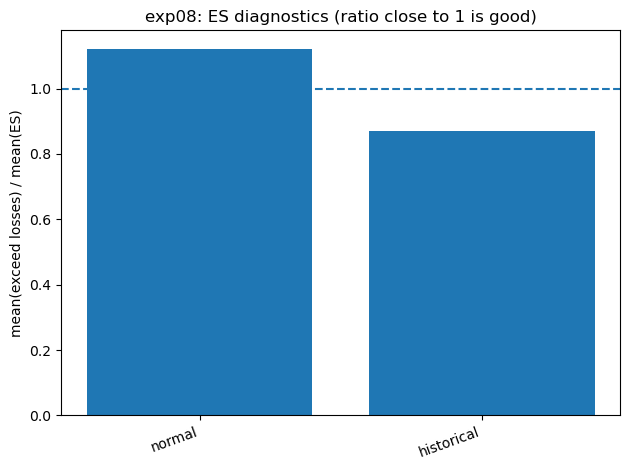

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp09_garch_es_ratio.png


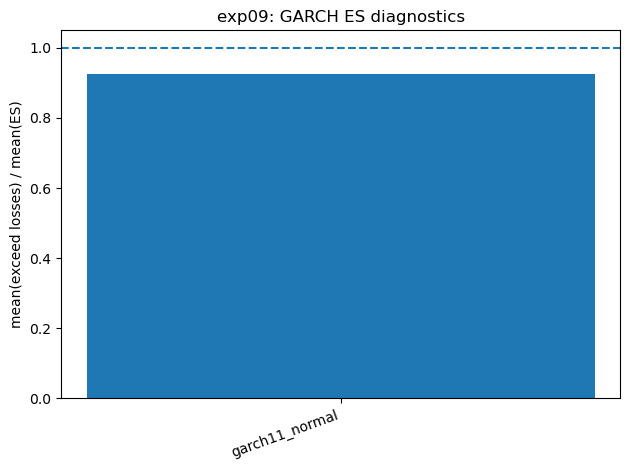

In [76]:
def plot_es_ratio(df: pd.DataFrame, title: str, fname: str):
    if df is None or df.empty:
        print("No ES backtest table.")
        return
    models = df["model"].astype(str).tolist()
    es_ratio = df["es_ratio"].to_numpy(dtype=float)

    x = np.arange(len(models))
    plt.figure()
    plt.bar(x, es_ratio)
    plt.axhline(1.0, linestyle="--")
    plt.xticks(x, models, rotation=20, ha="right")
    plt.ylabel("mean(exceed losses) / mean(ES)")
    plt.title(title)
    savefig(fname)
    plt.show()

plot_es_ratio(exp08, "exp08: ES diagnostics (ratio close to 1 is good)", "exp08_es_ratio.png")
plot_es_ratio(exp09, "exp09: GARCH ES diagnostics", "exp09_garch_es_ratio.png")

[loaded] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\tables\exp10_garch_t_series.csv  shape=(1547, 7)
[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp10_sigma_series.png


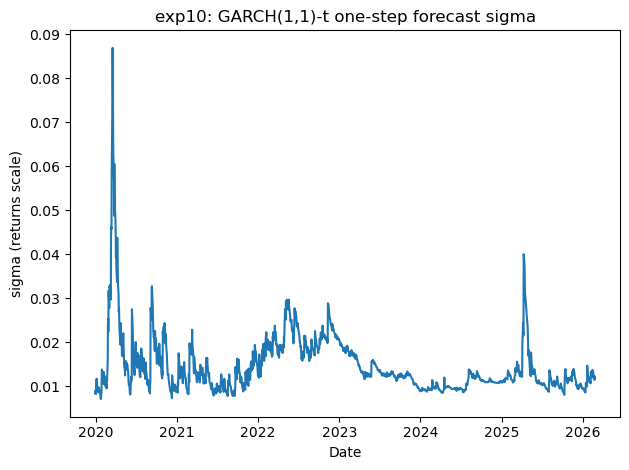

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\exp10_nu_series.png


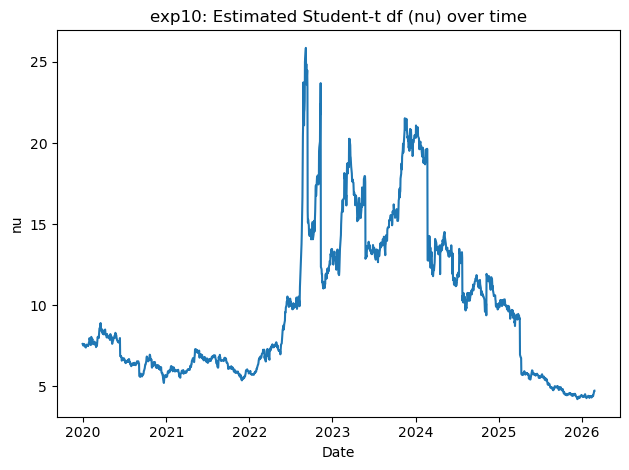

In [77]:
exp10_series = load_csv("exp10_garch_t_series.csv")

def plot_exp10_series(df):
    if df is None or df.empty:
        print("Missing exp10 series.")
        return

    # ensure Date index if present
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")

    plt.figure()
    plt.plot(df.index, df["sigma"].to_numpy(dtype=float))
    plt.title("exp10: GARCH(1,1)-t one-step forecast sigma")
    plt.ylabel("sigma (returns scale)")
    plt.xlabel("Date")
    savefig("exp10_sigma_series.png")
    plt.show()

    plt.figure()
    plt.plot(df.index, df["nu"].to_numpy(dtype=float))
    plt.title("exp10: Estimated Student-t df (nu) over time")
    plt.ylabel("nu")
    plt.xlabel("Date")
    savefig("exp10_nu_series.png")
    plt.show()

plot_exp10_series(exp10_series)


### Results show:

1. Static models strongly reject unconditional coverage (UC).
2. GARCH-normal improves independence but still underestimates tails.
3. GARCH-t passes both UC and IND tests.
4. Heavy tails combined with time-varying volatility are necessary for calibrated risk forecasts.

This is the central empirical finding of the study.

> ## compare FZ0 across models

### Scoring Rules vs Calibration Tests

Fissler–Ziegel (FZ) scores provide a strictly consistent joint scoring rule for VaR and ES.

However:
- A lower FZ score does not guarantee correct nominal coverage.
- Therefore, FZ scoring is used alongside Kupiec (UC) and Christoffersen (IND) tests.

Risk model evaluation should combine:
1. Coverage
2. Independence
3. Proper scoring rules

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\fz0_model_ranking.png


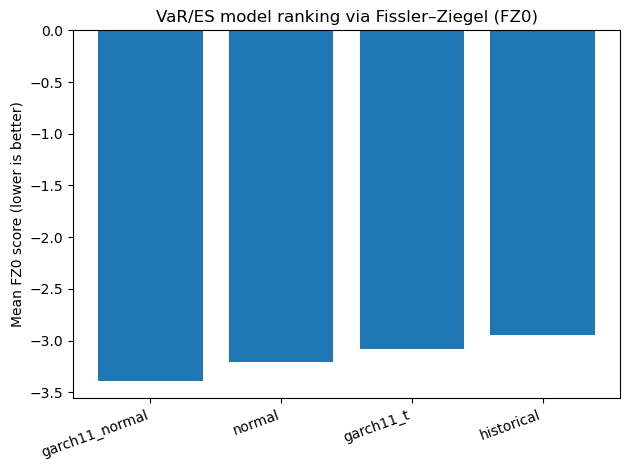

In [78]:
def plot_fz0_comparison(exp08, exp09, exp10):
    rows = []
    if exp08 is not None:
        rows.append(exp08[["model", "fz0_mean"]])
    if exp09 is not None:
        rows.append(exp09[["model", "fz0_mean"]])
    if exp10 is not None:
        rows.append(exp10[["model", "fz0_mean"]])

    if not rows:
        print("Missing fz0_mean in tables. Add fz0_mean to exp08/exp09/exp10 outputs first.")
        return

    df = pd.concat(rows, axis=0, ignore_index=True)
    df = df.dropna(subset=["fz0_mean"]).sort_values("fz0_mean")

    plt.figure()
    plt.bar(np.arange(len(df)), df["fz0_mean"].to_numpy(dtype=float))
    plt.xticks(np.arange(len(df)), df["model"].astype(str).tolist(), rotation=20, ha="right")
    plt.ylabel("Mean FZ0 score (lower is better)")
    plt.title("VaR/ES model ranking via Fissler–Ziegel (FZ0)")
    savefig("fz0_model_ranking.png")
    plt.show()

plot_fz0_comparison(exp08, exp09, exp10)

[saved] c:\Users\dipes\Desktop\Projects\montecarlo-var\paper\figures\var_exception_rate_ci.png


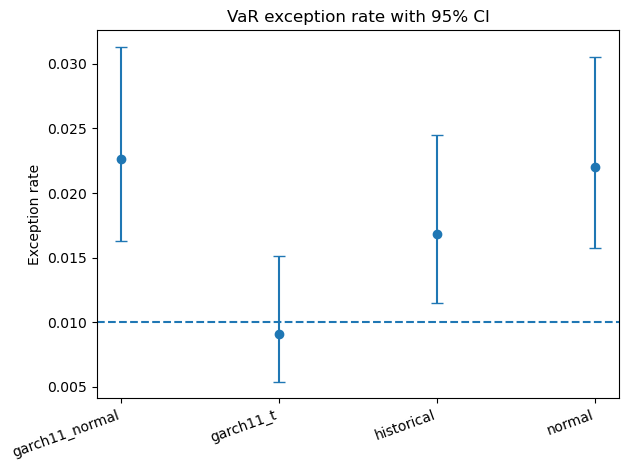

In [79]:
from src.stats_utils import wilson_ci

def plot_exception_rate_ci(*dfs, title="VaR exception rate with 95% CI", fname="exceptions_ci.png"):
    rows = []
    for df in dfs:
        if df is None or df.empty:
            continue
        for _, r in df.iterrows():
            n = int(r["n"])
            k = int(r["n_exceed"])
            alpha = float(r["alpha"])
            expected = float(1.0 - alpha)
            low, high = wilson_ci(k, n, conf=0.95)
            rows.append(
                {
                    "model": str(r["model"]),
                    "rate": float(r["exception_rate"]),
                    "expected": expected,
                    "low": low,
                    "high": high,
                    "n": n,
                    "k": k,
                }
            )

    if not rows:
        print("No tables provided.")
        return

    d = pd.DataFrame(rows)
    d = d.sort_values("model")

    x = np.arange(len(d))
    y = d["rate"].to_numpy(dtype=float)
    yerr_low = y - d["low"].to_numpy(dtype=float)
    yerr_high = d["high"].to_numpy(dtype=float) - y

    plt.figure()
    plt.errorbar(x, y, yerr=[yerr_low, yerr_high], fmt="o", capsize=4)
    plt.axhline(d["expected"].iloc[0], linestyle="--")
    plt.xticks(x, d["model"].tolist(), rotation=20, ha="right")
    plt.ylabel("Exception rate")
    plt.title(title)
    savefig(fname)
    plt.show()

plot_exception_rate_ci(exp08, exp09, exp10, fname="var_exception_rate_ci.png")

> ## Summary tables 



In [80]:
def summary_if(df: pd.DataFrame | None, name: str) -> None:
    print("\n" + "="*80)
    print(name)
    print("="*80)
    if df is None:
        print("(missing)")
        return
    with pd.option_context("display.max_columns", 200, "display.width", 160):
        print(df)

summary_if(exp01, "exp01_classical_var.csv")
summary_if(exp02, "exp02_normal_vs_t.csv")
summary_if(exp03, "exp03_asymptotics_summary.csv")
summary_if(exp04, "exp04_dkw_bounds.csv")
summary_if(exp05, "exp05_variance_reduction.csv")
summary_if(exp06, "exp06_importance_sampling.csv")
summary_if(exp07, "exp07_misspecification.csv")
summary_if(exp07n, "exp07_misspecification_normal.csv")
summary_if(exp08, "exp08_es_backtesting.csv")
summary_if(exp09, "exp09_garch_var_es.csv")
summary_if(exp10, "exp10_garch_t_var_es.csv")



exp01_classical_var.csv
         method  alpha       VaR      CVaR  n_sims  seed  n_hist  nu
0     normal_mc   0.99  0.036080  0.041658   20000     0    2047 NaN
1  bootstrap_mc   0.99  0.044041  0.056850   20000     0    2047 NaN

exp02_normal_vs_t.csv
         method  alpha       VaR      CVaR  n_sims  seed  n_hist   nu
0     normal_mc   0.99  0.036080  0.041658   20000     0    2047  NaN
1  bootstrap_mc   0.99  0.044041  0.056850   20000     0    2047  NaN
2          t_mc   0.99  0.051138  0.068834   20000     0    2047  5.0

exp03_asymptotics_summary.csv
   alpha  conf     n  reps   ref_var      rmse      bias  coverage  avg_ci_width  fhat_mean  fhat_min  fhat_max
0   0.99  0.95   250   200  0.043696  0.007026 -0.003389     0.755      0.118805   1.521429  0.001756  5.355574
1   0.99  0.95   500   200  0.043696  0.005210 -0.002260     0.790      0.015118   1.330653  0.346503  3.093221
2   0.99  0.95  1000   200  0.043696  0.003032 -0.001019     0.925      0.011240   1.189760  0.435

# Conclusion

This study demonstrates:

• Asymptotic quantile theory works well for large samples but is unstable in extreme tails.
• Distribution-free bounds (DKW) guarantee coverage but may be conservative.
• Antithetic variance reduction is ineffective for quantile estimators.
• Importance sampling can dramatically reduce variance when properly tuned.
• Static models fail VaR backtests under volatility clustering.
• GARCH(1,1) with Student-t innovations produces well-calibrated VaR and ES forecasts.

Overall, both conditional volatility and heavy tails are essential for realistic risk modeling.